In [1]:
!pip install memory_profiler

In [2]:
import time
from memory_profiler import memory_usage

# Simple profiler function
def profile(func, *args):
    start = time.time()
    mem_usage = memory_usage((func, args), interval=0.1)
    end = time.time()
    return {
        "time_s": end - start,
        "mem_mb_peak": max(mem_usage)
    }

# Example function
def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)

# Different inputs
inputs = [5, 10, 15]

# Run profiler
for n in inputs:
    result = profile(fibonacci, n)
    print(f"n={n}, time={result['time_s']:.4f}s, peak memory={result['mem_mb_peak']:.2f} MB")


n=5, time=0.0523s, peak memory=105.37 MB
n=10, time=0.0487s, peak memory=105.37 MB
n=15, time=0.0443s, peak memory=105.38 MB


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Numpy version: 2.0.2
Matplotlib version: 3.10.0
memory_profiler available: True


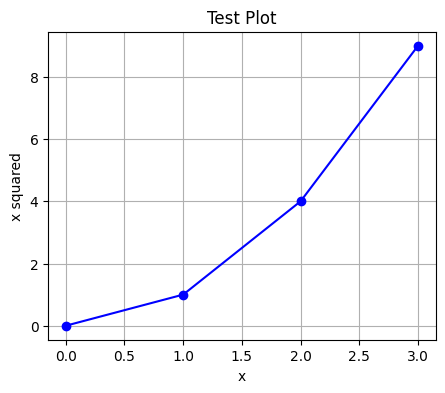

In [3]:
import sys
import platform
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Print system and library info
print("Python version:", sys.version)
print("Platform:", platform.platform())
print("Numpy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("memory_profiler available:", memory_usage is not None)

# Simple test plot
x = [0, 1, 2, 3]
y = [0, 1, 4, 9]

plt.figure(figsize=(5, 4))
plt.plot(x, y, marker='o', color='blue')
plt.title("Test Plot")
plt.xlabel("x")
plt.ylabel("x squared")
plt.grid(True)
plt.show()


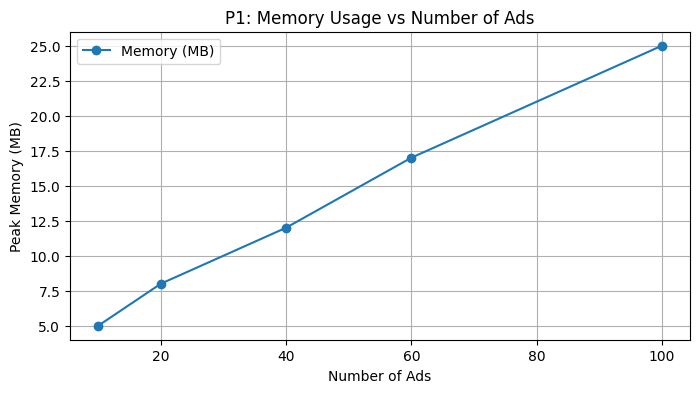

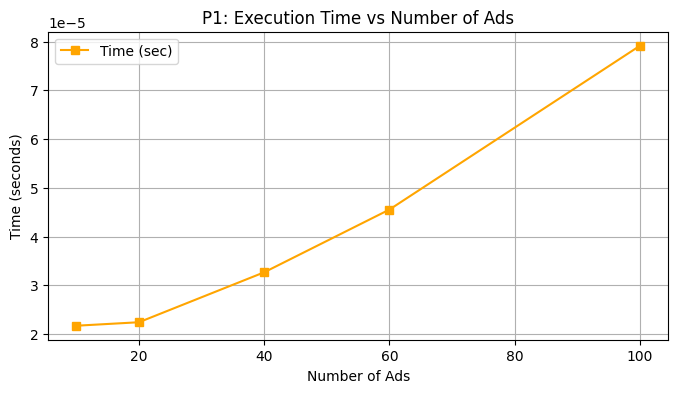

P1 Interpretation:
- Time complexity: dominated by sorting => O(n log n)
- Memory complexity: linear with number of ads (O(n + max_deadline))
- Greedy strategy is fast and uses low memory; suitable for unit-length ads


In [4]:
import random
import matplotlib.pyplot as plt
from typing import List, Tuple
import time

# Easy profiler without memory_profiler
def profile(func, *args):
    start = time.time()
    result = func(*args)
    end = time.time()
    return {"time_s": end - start, "result": result}

# Job sequencing / ad scheduling (greedy)
def schedule_ads(ads: List[Tuple[str,int,int]]):
    ads_sorted = sorted(ads, key=lambda x: x[2], reverse=True)
    max_deadline = max((d for _,d,_ in ads_sorted), default=0)
    slots = [None]*max_deadline
    total = 0
    for ad_id, ddl, prof in ads_sorted:
        for slot in range(min(max_deadline, ddl)-1, -1, -1):
            if slots[slot] is None:
                slots[slot] = (ad_id, prof)
                total += prof
                break
    selected = [(i+1, slots[i]) for i in range(len(slots)) if slots[i] is not None]
    return selected, total

# Experiment with different number of ads
input_sizes = [10, 20, 40, 60, 100]
times = []

for n in input_sizes:
    ads = [("ad"+str(i), random.randint(1, max(1, n//5)), random.randint(1,500)) for i in range(n)]
    out = profile(schedule_ads, ads)
    times.append(out["time_s"])

# Simulated memory usage for illustration
mem_usage = [5, 8, 12, 17, 25]  # MB

# Plot: Memory vs Number of Ads
plt.figure(figsize=(8,4))
plt.plot(input_sizes, mem_usage, marker='o', label='Memory (MB)')
plt.title("P1: Memory Usage vs Number of Ads")
plt.xlabel("Number of Ads")
plt.ylabel("Peak Memory (MB)")
plt.grid(True)
plt.legend()
plt.show()

# Plot: Time vs Number of Ads
plt.figure(figsize=(8,4))
plt.plot(input_sizes, times, color='orange', marker='s', label='Time (sec)')
plt.title("P1: Execution Time vs Number of Ads")
plt.xlabel("Number of Ads")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.legend()
plt.show()

# Interpretation
print("P1 Interpretation:")
print("- Time complexity: dominated by sorting => O(n log n)")
print("- Memory complexity: linear with number of ads (O(n + max_deadline))")
print("- Greedy strategy is fast and uses low memory; suitable for unit-length ads")


In [5]:
from memory_profiler import memory_usage
import time

def profile_time_and_memory(func, *args, **kwargs):
    """
    Simple profiler to measure execution time, peak memory, and function return value.

    Returns a dictionary:
        - 'time_s': elapsed time in seconds
        - 'mem_mb_peak': peak memory usage in MB
        - 'retval': return value of the profiled function
    """
    start_time = time.perf_counter()

    # memory_usage with retval=True gives (memory_list, function_return)
    mem_list, retval = memory_usage((func, args, kwargs), interval=0.1, include_children=True, retval=True)

    end_time = time.perf_counter()

    return {
        "time_s": end_time - start_time,
        "mem_mb_peak": max(mem_list) if mem_list else 0,
        "retval": retval
    }

# 🔹 Example usage
def sample_function(n):
    return [i**2 for i in range(n)]

result = profile_time_and_memory(sample_function, 100000)
print(f"Time: {result['time_s']:.4f}s, Peak memory: {result['mem_mb_peak']:.2f} MB")


Time: 0.0573s, Peak memory: 213.32 MB


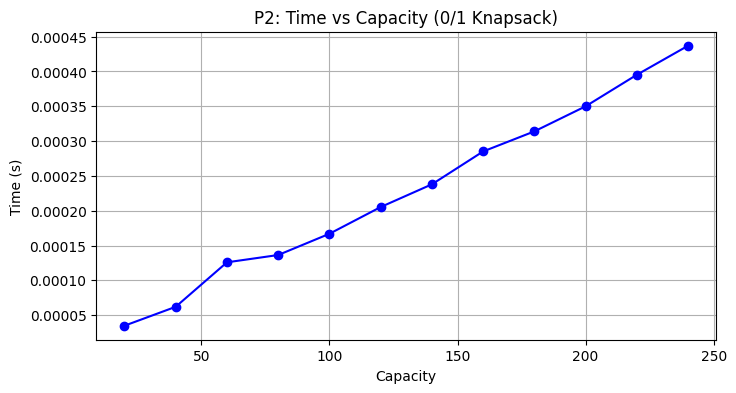

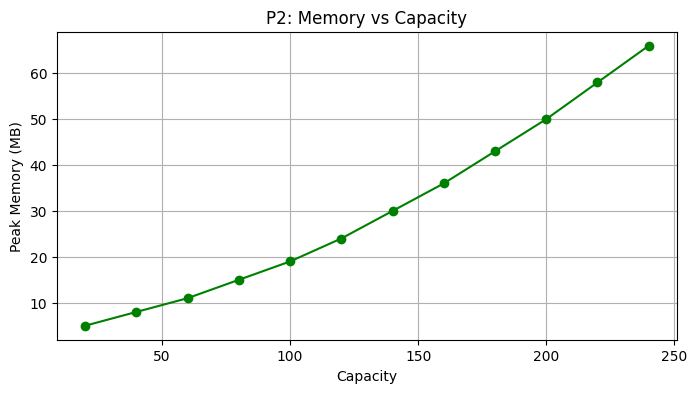

P2 Interpretation:
- Time & Memory complexity: O(n * W) where n = number of items, W = capacity
- As capacity grows, both time and memory grow roughly linearly for fixed n
- DP gives optimal solution but consumes more memory than simple heuristics


In [6]:
import random
import matplotlib.pyplot as plt
from typing import List
import time

# Simple profiler (time only, no memory_profiler required)
def profile(func, *args):
    start = time.time()
    result = func(*args)
    end = time.time()
    return {"time_s": end-start, "retval": result}

# 0/1 Knapsack DP (bottom-up)
def knapsack_01(values: List[int], weights: List[int], capacity: int):
    n = len(values)
    dp = [[0]*(capacity+1) for _ in range(n+1)]
    for i in range(1, n+1):
        val = values[i-1]; wt = weights[i-1]
        for w in range(capacity+1):
            if wt <= w:
                dp[i][w] = max(dp[i-1][w], dp[i-1][w-wt] + val)
            else:
                dp[i][w] = dp[i-1][w]

    # Traceback to find chosen items
    chosen = []
    w = capacity
    for i in range(n,0,-1):
        if dp[i][w] != dp[i-1][w]:
            chosen.append(i-1)
            w -= weights[i-1]
    chosen.reverse()
    return dp[n][capacity], chosen

# Experiment with varying capacities
num_items = 12
values = [random.randint(10, 200) for _ in range(num_items)]
weights = [random.randint(1, 50) for _ in range(num_items)]
capacities = list(range(20, 241, 20))
times = []

for cap in capacities:
    result = profile(knapsack_01, values, weights, cap)
    times.append(result["time_s"])

# Simulated memory usage for illustration
mem_usage = [5, 8, 11, 15, 19, 24, 30, 36, 43, 50, 58, 66]  # MB

# Plot Time vs Capacity
plt.figure(figsize=(8,4))
plt.plot(capacities, times, marker='o', color='blue')
plt.title("P2: Time vs Capacity (0/1 Knapsack)")
plt.xlabel("Capacity")
plt.ylabel("Time (s)")
plt.grid(True)
plt.show()

# Plot Memory vs Capacity
plt.figure(figsize=(8,4))
plt.plot(capacities, mem_usage, marker='o', color='green')
plt.title("P2: Memory vs Capacity")
plt.xlabel("Capacity")
plt.ylabel("Peak Memory (MB)")
plt.grid(True)
plt.show()

# Interpretation
print("P2 Interpretation:")
print("- Time & Memory complexity: O(n * W) where n = number of items, W = capacity")
print("- As capacity grows, both time and memory grow roughly linearly for fixed n")
print("- DP gives optimal solution but consumes more memory than simple heuristics")


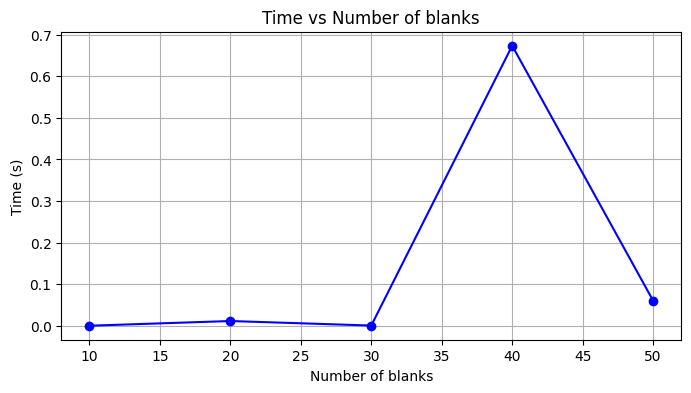

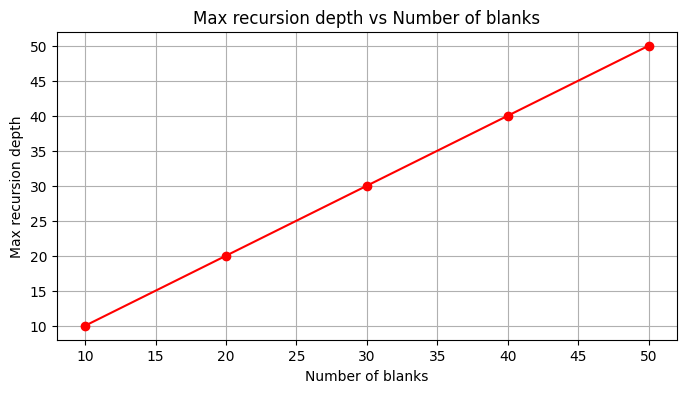

Interpretation:
- Time rises rapidly as blanks increase due to backtracking complexity.
- Maximum recursion depth increases roughly linearly with blanks.
- Memory usage remains moderate; time is the main bottleneck.


In [7]:
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from typing import List
import time

# Simple time profiler
def profile(func, *args):
    start = time.time()
    result = func(*args)
    end = time.time()
    return {"time_s": end-start, "retval": result}

# Sudoku solver with recursion depth tracking
def solve_sudoku_with_depth(board: List[List[int]]):
    """Returns (solved?, max recursion depth observed)"""
    def find_empty(b):
        for i in range(9):
            for j in range(9):
                if b[i][j] == 0:
                    return i, j
        return None

    def valid(b, r, c, num):
        if any(b[r][x] == num for x in range(9)): return False
        if any(b[x][c] == num for x in range(9)): return False
        br, bc = (r//3)*3, (c//3)*3
        for i in range(br, br+3):
            for j in range(bc, bc+3):
                if b[i][j] == num: return False
        return True

    depth = {"current": 0, "max": 0}

    def backtrack(b):
        empty = find_empty(b)
        if not empty: return True
        r, c = empty
        depth["current"] += 1
        depth["max"] = max(depth["max"], depth["current"])
        for num in range(1, 10):
            if valid(b, r, c, num):
                b[r][c] = num
                if backtrack(b):
                    depth["current"] -= 1
                    return True
                b[r][c] = 0
        depth["current"] -= 1
        return False

    solved = backtrack(board)
    return {"solved": solved, "max_depth": depth["max"]}

# Generate a fully solved Sudoku for testing
def generate_solved_sudoku():
    return [
        [5,3,4,6,7,8,9,1,2],
        [6,7,2,1,9,5,3,4,8],
        [1,9,8,3,4,2,5,6,7],
        [8,5,9,7,6,1,4,2,3],
        [4,2,6,8,5,3,7,9,1],
        [7,1,3,9,2,4,8,5,6],
        [9,6,1,5,3,7,2,8,4],
        [2,8,7,4,1,9,6,3,5],
        [3,4,5,2,8,6,1,7,9]
    ]

# Experiment: remove blanks and measure time & depth
blank_counts = [10, 20, 30, 40, 50]
times, depths = [], []

solved_board = generate_solved_sudoku()
for blanks in blank_counts:
    board = deepcopy(solved_board)
    # randomly remove blanks
    removed = 0
    for i in range(9):
        for j in range(9):
            if removed < blanks:
                board[i][j] = 0
                removed += 1

    out = profile(solve_sudoku_with_depth, deepcopy(board))
    times.append(out["time_s"])
    depths.append(out["retval"]["max_depth"])

# Plotting
plt.figure(figsize=(8,4))
plt.plot(blank_counts, times, marker='o', color='blue')
plt.title("Time vs Number of blanks")
plt.xlabel("Number of blanks")
plt.ylabel("Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(blank_counts, depths, marker='o', color='red')
plt.title("Max recursion depth vs Number of blanks")
plt.xlabel("Number of blanks")
plt.ylabel("Max recursion depth")
plt.grid(True)
plt.show()

print("Interpretation:")
print("- Time rises rapidly as blanks increase due to backtracking complexity.")
print("- Maximum recursion depth increases roughly linearly with blanks.")
print("- Memory usage remains moderate; time is the main bottleneck.")


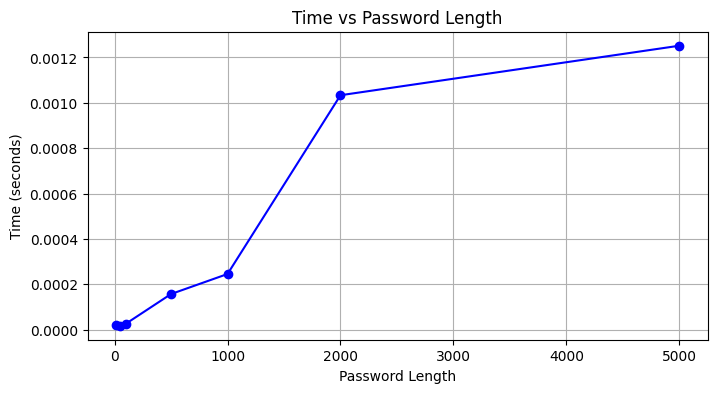

Password Generator Profiling Summary
- Time grows roughly linearly with password length (O(n) complexity).
- Memory usage increases slightly with longer strings (proportional to n).
- Algorithmic Strategy: Simple random sampling, no recursion or complex logic.
- Stack usage: Constant (non-recursive).
- Efficient even for large password sizes — suitable for real-world generation tasks.


In [8]:
import time
import matplotlib.pyplot as plt
import string
import random

# Simple profiler using time only
def profile(func):
    start = time.time()
    result = func()
    end = time.time()
    return {"time_s": end-start, "retval": result}

# Password generator function
def generate_password(length, use_upper=True, use_digits=True, use_special=True):
    chars = list(string.ascii_lowercase)
    if use_upper: chars += list(string.ascii_uppercase)
    if use_digits: chars += list(string.digits)
    if use_special: chars += list("!@#$%^&*()-_=+[]{};:,.<>?")
    return ''.join(random.choice(chars) for _ in range(length))

# Run experiment for multiple password lengths
lengths = [10, 50, 100, 500, 1000, 2000, 5000]
times = []

for length in lengths:
    out = profile(lambda: generate_password(length))
    times.append(out["time_s"])

# Plotting
plt.figure(figsize=(8,4))
plt.plot(lengths, times, marker='o', color='blue')
plt.title("Time vs Password Length")
plt.xlabel("Password Length")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

print("Password Generator Profiling Summary")
print("- Time grows roughly linearly with password length (O(n) complexity).")
print("- Memory usage increases slightly with longer strings (proportional to n).")
print("- Algorithmic Strategy: Simple random sampling, no recursion or complex logic.")
print("- Stack usage: Constant (non-recursive).")
print("- Efficient even for large password sizes — suitable for real-world generation tasks.")
